In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, SimpleRNN

In [2]:
original_df = pd.read_csv('sales_per_store_per_sku_ord_2.csv')
original_df

,store,sku,date,sales
0,1186,601516,2016-02-04,20.0
1,1186,601516,2016-02-05,11.0
2,1186,601516,2016-02-06,10.0
3,1186,601516,2016-02-08,10.0
4,1186,601516,2016-02-09,10.0
...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0
161525,194,100085056000002,2021-05-30,3.0
161526,194,100085056000002,2021-05-31,1.0
161527,194,100085056000002,2021-06-12,2.0


In [3]:
original_df['date'] = pd.to_datetime(original_df['date'])
original_df['day_count'] = (original_df['date'] - original_df['date'].min()).dt.days
original_df['month_count'] = (original_df['date'].dt.year - original_df['date'].min().year) * 12 + original_df['date'].dt.month - original_df['date'].min().month
original_df['week_number'] = original_df['date'].dt.isocalendar().week
original_df['year_count'] = original_df['date'].dt.year - original_df['date'].min().year
original_df['day_of_week'] = original_df['date'].dt.dayofweek
original_df['day_of_month'] = original_df['date'].dt.day
original_df['day_of_week_name'] = original_df['date'].dt.day_name()
original_df['month_of_year'] = original_df['date'].dt.month
original_df['year'] = original_df['date'].dt.year
original_df

,store,sku,date,sales,day_count,month_count,week_number,year_count,day_of_week,day_of_month,day_of_week_name,month_of_year,year
0,1186,601516,2016-02-04,20.0,1098,36,5,3,3,4,Thursday,2,2016
1,1186,601516,2016-02-05,11.0,1099,36,5,3,4,5,Friday,2,2016
2,1186,601516,2016-02-06,10.0,1100,36,5,3,5,6,Saturday,2,2016
3,1186,601516,2016-02-08,10.0,1102,36,6,3,0,8,Monday,2,2016
4,1186,601516,2016-02-09,10.0,1103,36,6,3,1,9,Tuesday,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161524,194,100085056000002,2021-05-27,1.0,3037,99,21,8,3,27,Thursday,5,2021
161525,194,100085056000002,2021-05-30,3.0,3040,99,21,8,6,30,Sunday,5,2021
161526,194,100085056000002,2021-05-31,1.0,3041,99,22,8,0,31,Monday,5,2021
161527,194,100085056000002,2021-06-12,2.0,3053,100,23,8,5,12,Saturday,6,2021


In [4]:

agg_month_item_df = original_df.pivot_table(index='month_count', columns='sku', values='sales', fill_value=0, aggfunc=np.sum)
agg_month_item_df = agg_month_item_df.reindex(list(range(agg_month_item_df.index.min(), agg_month_item_df.index.max()+1)),fill_value=0)
agg_month_item_df

sku,601105,601210,601500,601515,601516,601900,601910,601917,601920,601950,...,100659301000002,201080005300003,201080005300004,201082015300003,201090015300002,201888006000001,201888014000001,201999999990002,201999999990006,201999999990007
month_count,,,,,,,,,,,,,,,,,,,,,
0,4871,1138,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7641,1861,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5097,1276,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6739,2819,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3854,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0,0,0,0,0,325,0,0,133,142,...,0,0,0,0,0,6,652,38,0,82
115,0,0,0,0,0,242,0,0,325,122,...,0,0,0,0,0,13,792,42,0,86
116,0,0,0,0,0,275,0,0,434,190,...,0,0,0,0,0,1,673,65,0,10


In [5]:
sku_df = agg_month_item_df[[601900]] 
sku_df = sku_df.reindex(list(range(sku_df.index.min(), sku_df.index.max()+1)),fill_value=0) 
sku_df

sku,601900
month_count,
0,0
1,0
2,0
3,0
4,0
...,...
114,325
115,242
116,275


<AxesSubplot: xlabel='month_count'>

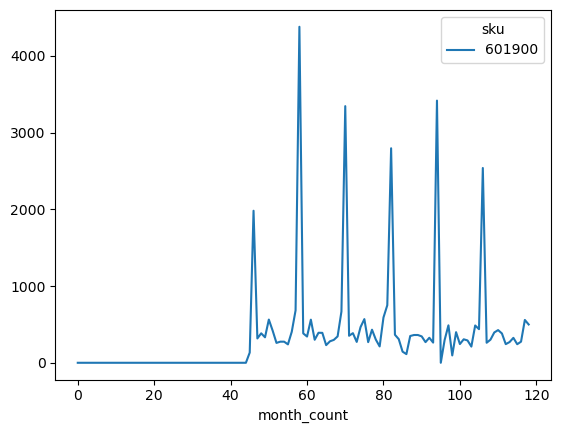

In [6]:
sku_df.plot()

In [7]:
train = sku_df.iloc[45:90]
test = sku_df.iloc[90:]
     

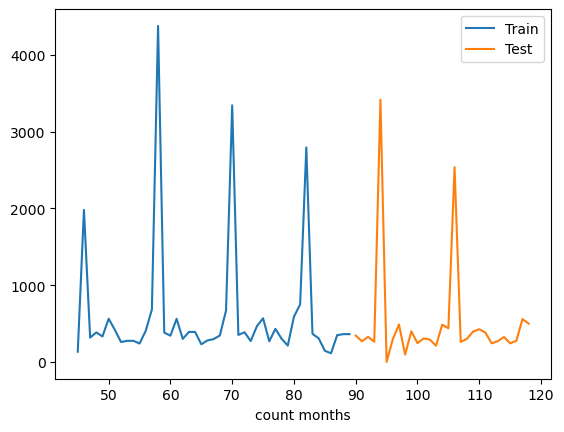

In [8]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel("count months")
plt.legend()

In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator


In [12]:

# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [13]:

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00468933 0.43798359 0.04783118 0.06354045 0.05134818 0.10550996
 0.07174678 0.03423212 0.03798359 0.03798359 0.02977726 0.06822978]
Predict this y: 
 [[0.13364596]]


In [14]:

# We do the same thing, but now instead for 12 months
n_input = 15
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
# define lstm model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [16]:
# define gru model
gru_model = Sequential()
gru_model.add(GRU(100, return_sequences=True, input_shape=(n_input, n_features)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(100, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(25))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

In [17]:
# define rnn model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, return_sequences=True, input_shape=(n_input, n_features)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(100, return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(25))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

In [18]:
# fit lstm model
lstm_model.fit(generator,epochs=100)

Epoch 1/100
30/30 [==============================] - 2s 8ms/step - loss: 0.0324
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0254
Epoch 4/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0310
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0250
Epoch 8/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 9/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0261
Epoch 10/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0267
Epoch 11/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0230
Epoch 12/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0235
Epoch 13/100
30/30 [=================

In [19]:
# fit gru model
gru_model.fit(generator,epochs=100)

Epoch 1/100
30/30 [==============================] - 2s 8ms/step - loss: 0.0335
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0306
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0276
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 5/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0250
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 8/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0293
Epoch 9/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0285
Epoch 10/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0262
Epoch 11/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 12/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 13/100
30/30 [=================

In [20]:
# fit rnn model
rnn_model.fit(generator,epochs=100)

Epoch 1/100
30/30 [==============================] - 1s 4ms/step - loss: 0.6179
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3727
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1934
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1303
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1244
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0670
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0686
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0728
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0496
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0327
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 13/100
30/30 [=================

In [21]:
last_train_batch = scaled_train[-n_input:]

In [22]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [23]:
lstm_model.predict(last_train_batch) , gru_model.predict(last_train_batch), rnn_model.predict(last_train_batch)

(array([[0.04853011]], dtype=float32),
 array([[0.05753203]], dtype=float32),
 array([[0.0800086]], dtype=float32))

In [24]:
scaled_test[0]

array([0.05416178])

In [25]:
lstm_test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = lstm_model.predict(current_batch)[0]
    
    # append the prediction into the array
    lstm_test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [26]:
gru_test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = gru_model.predict(current_batch)[0]
    
    # append the prediction into the array
    gru_test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
rnn_test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = rnn_model.predict(current_batch)[0]
    
    # append the prediction into the array
    rnn_test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
lstm_true_predictions = scaler.inverse_transform(lstm_test_predictions)
gru_true_predictions = scaler.inverse_transform(gru_test_predictions)
rnn_true_predictions = scaler.inverse_transform(rnn_test_predictions)

In [29]:
test['LSTM Predictions'] = lstm_true_predictions
test['GRU Predictions'] = gru_true_predictions
test['RNN Predictions'] = rnn_true_predictions


C:\Users\Oran Nahum\AppData\Local\Temp\ipykernel_6180\4126403489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = lstm_true_predictions
C:\Users\Oran Nahum\AppData\Local\Temp\ipykernel_6180\4126403489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GRU Predictions'] = gru_true_predictions
C:\Users\Oran Nahum\AppData\Local\Temp\ipykernel_6180\4126403489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [30]:
test

sku,601900,LSTM Predictions,GRU Predictions,RNN Predictions
month_count,,,,
90,344,319.980932,358.374097,454.236663
91,269,327.752359,372.491988,445.566129
92,326,390.124035,498.927514,872.862809
93,263,832.515646,1409.606098,783.384633
94,3416,2490.212823,1660.912592,1806.405638
95,0,443.279857,330.967147,188.896105
96,296,340.098904,270.627338,359.633440
97,488,324.558703,290.684872,195.027567
98,96,320.983472,314.861050,302.861951


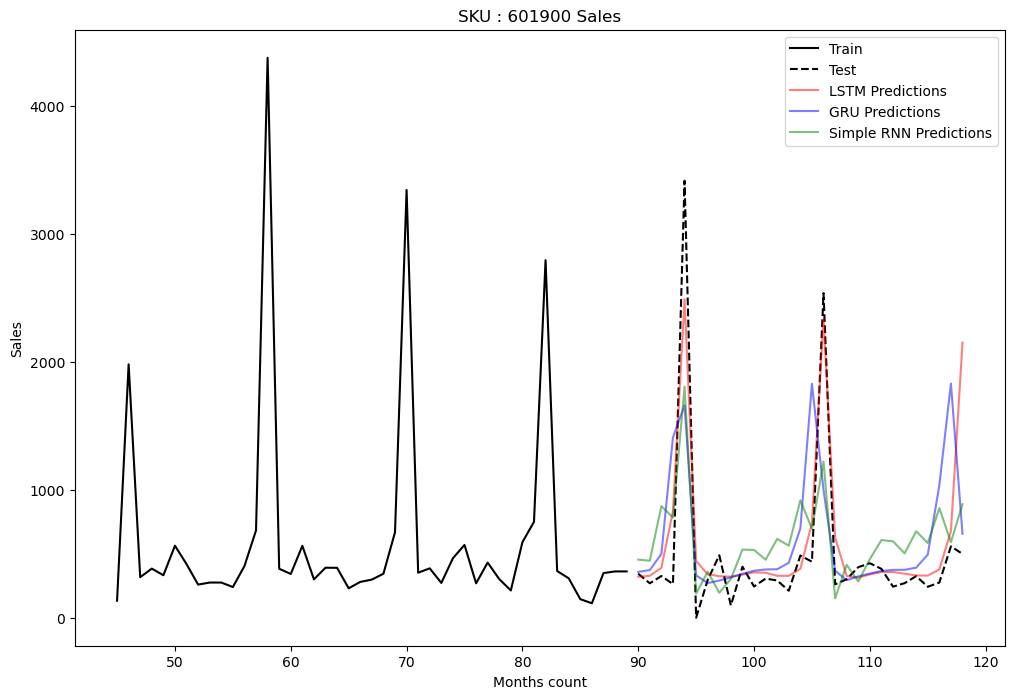

In [31]:
plt.figure(figsize=(12,8))
plt.plot(train,'black', label='Train')
plt.plot(test[601900],'--',color ='black',  label='Test')
plt.plot(test["LSTM Predictions"],'r',alpha=0.5, label='LSTM Predictions')
plt.plot(test["GRU Predictions"],'b', alpha=0.5,label='GRU Predictions')
plt.plot(test["RNN Predictions"],'g', alpha=0.5,label='Simple RNN Predictions')
plt.xlabel("Months count")
plt.ylabel("Sales")
plt.title("SKU : 601900 Sales")
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_LSTM=sqrt(mean_squared_error(test[601900],test['LSTM Predictions']))
rmse_GRU=sqrt(mean_squared_error(test[601900],test['GRU Predictions']))
rmse_RNN=sqrt(mean_squared_error(test[601900],test['RNN Predictions']))

print("LSTM MSE:", rmse_LSTM)
print("GRU MSE:", rmse_GRU)
print("RNN MSE:", rmse_RNN)

LSTM MSE: 396.9872112405116
GRU MSE: 627.237547003419
RNN MSE: 480.97159469265114
